In [223]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# various backends from qibo and providers
from qibo.backends import NumpyBackend, PyTorchBackend
from qibojit.backends import NumbaBackend
from qiboml.backends import TensorflowBackend

# qibo objects
import qibo
from qibo import hamiltonians

# qiboml models, operations and frontends constructors
from qiboml.models import encoding, ansatze, decoding
from qiboml.operations.differentiation import PSR
import qiboml.models.pytorch as pytorch_frontend

In [224]:
from importlib import reload
reload(encoding)

<module 'qiboml.models.encoding' from '/home/matteo/Documents/PhD/qiboml/src/qiboml/models/encoding.py'>

In [401]:
import numpy as np

def generate_data(n, radius=0.3, center=(0.5, 0.5)):
    """Generate data in-out a circle."""
    data = np.random.rand(n, 2)
    # Calculate distances from each point to the circle center
    distances = np.linalg.norm(data - np.array(center), axis=1)
    # Label as -1 if inside the circle, +1 if outside
    labels = [-1 if dist <= radius else +1 for dist in distances]
    return np.array(data), np.array(labels)


def train_model(model, data, labels, epochs, nmessage=1):
    """Train model using Binary Cross Entropy loss without sigmoid activation,
       classifying outputs based on positive and negative values."""
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    loss_f = torch.nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for raw model outputs
    accuracies = []

    for ep in range(epochs):
        avg_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for x, y in zip(data, labels):
            optimizer.zero_grad()
            prediction = model(x)  # Get raw model outputs

            # Convert labels from {-1, 1} to {0, 1}
            binary_labels = (y + 1) / 2  # Convert -1 to 0, +1 to 1

            # Calculate loss directly from model outputs
            loss = loss_f(prediction.view(-1), binary_labels.view(-1))  # BCE with logits expects raw outputs
            
            # Perform backward pass and optimization step
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()  # Accumulate loss

            # Convert predictions to binary classification: +1 if >= 0, -1 if < 0
            preds = torch.where(prediction >= 0, torch.tensor(1.0), torch.tensor(-1.0))
            correct_predictions += (preds.view(-1) == y.view(-1)).sum().item()
            total_predictions += preds.size(0)  # Update total predictions based on batch size

        avg_loss /= len(data)  # Calculate average loss
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracies.append(accuracy)

        if (ep + 1) % nmessage == 0:
            print(f"Epoch {ep + 1}: avg loss: {avg_loss:.4f}, accuracy: {accuracy:.4f}")


In [404]:
data, labels = generate_data(250)

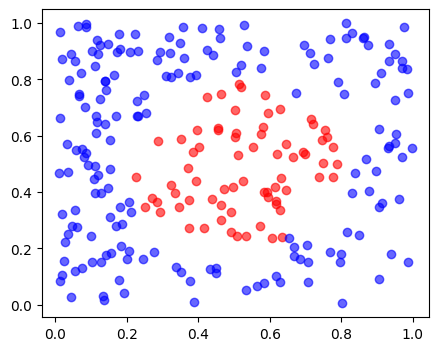

In [405]:
plt.figure(figsize=(5,4))
plt.scatter(data[labels == -1].T[0], data[labels == -1].T[1], color="red", alpha=0.6)
plt.scatter(data[labels == +1].T[0], data[labels == +1].T[1], color="blue", alpha=0.6)

In [406]:
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

In [415]:
# This is quite ambiguous
qibo.set_backend("pytorch")
backend = NumpyBackend()
frontend = pytorch_frontend

[Qibo 0.2.13|INFO|2024-10-28 18:24:02]: Using pytorch backend on cpu


In [416]:
np.random.seed(42)

In [424]:
ndim = 2
nqubits = 2
nshots = None

In [425]:
obs = hamiltonians.Z(nqubits=nqubits)

In [426]:
encoding_layer = encoding.PhaseEncoding(nqubits=nqubits, qubits=[0,1])
training_layer = ansatze.ReuploadingCircuit(nqubits=nqubits, qubits=[0,1], nlayers=3) 
decoding_layer = decoding.Expectation(
    nqubits=nqubits,
    qubits=[0,1],
    backend=backend,
    observable=obs,
    nshots=None,
)

In [427]:
encoding_layer.circuit.draw()

q0: ─RZ─
q1: ─RZ─


In [428]:
q_model = frontend.QuantumModel(
    encoding=encoding_layer, 
    circuit=training_layer, 
    decoding=decoding_layer,
    differentiation_rule=PSR(),
)

In [430]:
losses = train_model(model=q_model, data=data, labels=labels, epochs=5, nmessage=1)

Epoch 1: avg loss: 0.6183, accuracy: 0.6960
Epoch 2: avg loss: 0.6112, accuracy: 0.7160
Epoch 3: avg loss: 0.6067, accuracy: 0.7160
Epoch 4: avg loss: 0.6062, accuracy: 0.7160
Epoch 5: avg loss: 0.6158, accuracy: 0.7160
